Информация об имеющихся в свободной продаже зимних шинах, где указаны основные параметры (см. наименования столбцов), ориентируясь на которые покупатели выбирают соответствующий товар, поможет покупателю выбрать оптимальный для него вариант покупки.
Требуемые данные возьму с сайта "Колоса-даром" (данные по Тамбовской области)

In [ ]:
import pandas as pd
import numpy as np
import requests
import bs4
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.models import load_model

Парсим данные с сайта Колеса-даром

In [ ]:
r = requests.get('https://tambov.kolesa-darom.ru/catalog/avto/shiny/')
print(r)

<Response [200]>


In [ ]:
# Создаем список из страниц, на которых по 20 моделей шин
url_page = []
for i in range(1,235):
  url = f'https://tambov.kolesa-darom.ru/catalog/avto/shiny/nav/page-{i}/'
  url_page.append(url)

# Функция записи данных в датафрейм
def write_csv(data):
    with open('tires.csv', 'a', ) as f:
        df = csv.writer(f)
        df.writerow((data['Производитель'], data['Модель'], data['Ширина'], data['Профиль'],
                     data['Диаметр'], data['Индекс скорости'], 
                     data['Индекс нагрузки'], data['Цена']
                     ))
        
# Скачивание данных и запись их в csv-файл
for i in url_page:
  req = requests.get(i)
  page_soup_3 = bs4.BeautifulSoup(req.text)
  articles = page_soup_3.find_all('div', class_='product-card__inner')

  for div in articles:
    Manufacturer = div.find('p', class_='product-card-properties__title').text.split(' ')[0] # производитель
    Model = div.find('p', class_='product-card-properties__title').text.strip().split(' ', 1)[1] #  модель
    Width = div.find('li', class_="product-card-properties__item kd-chip-new").text.strip() # ширина
    Profile = div.find('li', class_="product-card-properties__item kd-chip-new").find_next().text.strip() # профиль
    Diameter = div.find('li', class_="product-card-properties__item kd-chip-new").find_next().find_next().text.strip('RC') # диаметр
    Speed_index = div.find('li', class_="product-card-properties__item kd-chip-new").find_next().find_next().find_next().text.strip() # индекс скорости
    Load_index = div.find('li', class_="product-card-properties__item kd-chip-new").find_next().find_next().find_next().find_next().find_next().text.strip() # индекс нагрузки
    Price = div.find('div', class_="product-card__actions").find_next().text.rstrip(' ₽')
        
    data = {'Производитель':Manufacturer, 'Модель':Model, 'Ширина':Width,
            'Профиль':Profile, 'Диаметр':Diameter, 'Индекс скорости':Speed_index, 
            'Индекс нагрузки':Load_index, 'Цена':Price}
    write_csv(data)

In [ ]:
df = pd.read_csv('/content/tires (1).csv')
df.columns = ['Производитель','Модель', 'Ширина', 'Профиль', 'Диаметр, R','Индекс скорости', 'Индекс нагрузки', 'Цена']
df


Производитель                Модель  Ширина Профиль Диаметр, R  \
0          Pirelli       Winter Ice Zero   215.0      65         17   
1         Michelin         X-Ice North 4   195.0      65         15   
2         Goodyear      Ultra Grip Ice 2   225.0      50         17   
3          Pirelli     Winter Ice Zero 2   215.0      55         16   
4          Pirelli   Scorpion Ice Zero 2   235.0      55         18   
...            ...                   ...     ...     ...        ...   
4674          Ling    Long Crosswind M/T   215.0      75         15   
4675          Ling  Long Grip Master C/S   275.0      45         21   
4676       Nankang                  NS20   215.0      45         17   
4677        Sailun           Atrezzo ZSR   235.0      35         19   
4678      Triangle                 TC101   205.0      55         17   

     Индекс скорости Индекс нагрузки    Цена  
0                  T             103  11 350  
1                  T              95   7 600  
2                  T              98  10 470  
3                  T              97  11 240  
4                  H             104  17 050  
...              ...             ...     ...  
4674               Q             100   7 520  
4675               W             110   9 940  
4676               W              91   5 970  
4677               Y              91   8 520  
4678               W              95   5 140  

[4679 rows x 8 columns]

Приведение данных в надлежащий вид

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4679 entries, 0 to 4678
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Производитель    4679 non-null   object 
 1   Модель           4679 non-null   object 
 2   Ширина           4679 non-null   float64
 3   Профиль          4679 non-null   object 
 4   Диаметр, R       4669 non-null   object 
 5   Индекс скорости  4675 non-null   object 
 6   Индекс нагрузки  4672 non-null   object 
 7   Цена             4679 non-null   object 
dtypes: float64(1), object(7)
memory usage: 292.6+ KB


In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Производитель    4662 non-null   object 
 1   Модель           4662 non-null   object 
 2   Ширина           4662 non-null   float64
 3   Профиль          4662 non-null   object 
 4   Диаметр, R       4662 non-null   object 
 5   Индекс скорости  4662 non-null   object 
 6   Индекс нагрузки  4662 non-null   object 
 7   Цена             4662 non-null   object 
dtypes: float64(1), object(7)
memory usage: 291.5+ KB


In [ ]:
# В датасете есть "косяки", посмотрим на них:
a = df[df['Индекс скорости'] <')']
a

Производитель                    Модель  Ширина Профиль Диаметр, R  \
1868      Yokohama              W.Drive WY01   185.0    R14C          Q   
3084          Кама           365 LT (НК-243)   175.0    R16C          N   
3308       Белшина                    Би-522   175.0    R16C          N   
3343       Белшина                    Би-522   175.0    R16C          N   
3362       Белшина                    Би-522   175.0    R16C          N   
4542           АШК  Forward Professional 462   175.0    R16C          N   

     Индекс скорости Индекс нагрузки   Цена  
1868   (до 160 км/ч)     (до 850 кг)  8 190  
3084   (до 140 км/ч)     (до 750 кг)  5 050  
3308   (до 140 км/ч)     (до 825 кг)  4 960  
3343   (до 140 км/ч)     (до 825 кг)  4 960  
3362   (до 140 км/ч)     (до 825 кг)  4 420  
4542   (до 140 км/ч)     (до 750 кг)  4 180

In [ ]:
# удалим их, поскольку их немного
df = df.drop(df.index[[1868, 3084, 3308, 3343, 3362, 4542]])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656 entries, 0 to 4655
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Производитель    4656 non-null   object 
 1   Модель           4656 non-null   object 
 2   Ширина           4656 non-null   float64
 3   Профиль          4656 non-null   object 
 4   Диаметр, R       4656 non-null   object 
 5   Индекс скорости  4656 non-null   object 
 6   Индекс нагрузки  4656 non-null   object 
 7   Цена             4656 non-null   object 
dtypes: float64(1), object(7)
memory usage: 291.1+ KB


In [ ]:
# присваиваем данным столбца "Производитель" числовые значения
df1 = list(set(df['Производитель']))
dict1 = {}
for i in range(len(df1)):
  dict1.update({df1[i]:i})
dict1

{'Cordiant': 0,
 'Habilead': 1,
 'Roadmarch': 2,
 'Joyroad': 3,
 'Tunga': 4,
 'Matador': 5,
 'Hankook': 6,
 'Yokohama': 7,
 'Continental': 8,
 'Landsail': 9,
 'Goodyear': 10,
 'Laufenn': 11,
 'Nexen': 12,
 'Кама': 13,
 'Dunlop': 14,
 'Киров': 15,
 'Bridgestone': 16,
 'BFGoodrich': 17,
 'Evergreen': 18,
 'Michelin': 19,
 'Viatti': 20,
 'Tigar': 21,
 'Doublestar': 22,
 'Nokian': 23,
 'Ling': 24,
 'Белшина': 25,
 'General': 26,
 'Falken': 27,
 'Centara': 28,
 'Pirelli': 29,
 'Kumho': 30,
 'Gislaved': 31,
 'Sailun': 32,
 'Nankang': 33,
 'Toyo': 34,
 'Firestone': 35,
 'Triangle': 36,
 'АШК': 37,
 'Roadstone': 38}

In [ ]:
# присваиваем данным столбца "Индекс скорости" числовые значения
df3 = list(set(df['Индекс скорости']))
dict3 = {}
for i in range(len(df3)):
  dict3.update({df3[i]:i})
dict3

{'H': 0,
 'N': 1,
 'V': 2,
 'Y': 3,
 'P': 4,
 'T': 5,
 'W': 6,
 'S': 7,
 'R': 8,
 'Q': 9}

In [ ]:
# создадим новые столбцы, но уже с числовыми значениями
df['Производитель_числ'] = ''
df['Индекс скорости_числ'] = ''
for index, row in df.iterrows():
  df['Производитель_числ'].iloc[index] = dict1[row['Производитель']]
  df['Индекс скорости_числ'].iloc[index] = dict3[row['Индекс скорости']]
df

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Производитель                Модель  Ширина Профиль Диаметр, R  \
0          Pirelli       Winter Ice Zero   215.0      65         17   
1         Michelin         X-Ice North 4   195.0      65         15   
2         Goodyear      Ultra Grip Ice 2   225.0      50         17   
3          Pirelli     Winter Ice Zero 2   215.0      55         16   
4          Pirelli   Scorpion Ice Zero 2   235.0      55         18   
...            ...                   ...     ...     ...        ...   
4651          Ling    Long Crosswind M/T   215.0      75         15   
4652          Ling  Long Grip Master C/S   275.0      45         21   
4653       Nankang                  NS20   215.0      45         17   
4654        Sailun           Atrezzo ZSR   235.0      35         19   
4655      Triangle                 TC101   205.0      55         17   

     Индекс скорости Индекс нагрузки    Цена Производитель_числ  \
0                  T             103  11 350                 29   
1                  T              95   7 600                 19   
2                  T              98  10 470                 10   
3                  T              97  11 240                 29   
4                  H             104  17 050                 29   
...              ...             ...     ...                ...   
4651               Q             100   7 520                 24   
4652               W             110   9 940                 24   
4653               W              91   5 970                 33   
4654               Y              91   8 520                 32   
4655               W              95   5 140                 36   

     Индекс скорости_числ  
0                       5  
1                       5  
2                       5  
3                       5  
4                       0  
...                   ...  
4651                    9  
4652                    6  
4653                    6  
4654                    3  
4655                    6  

[4656 rows x 10 columns]

In [ ]:
# изменим типы данных на числовые
df[[ 'Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']] = df[[ 'Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ' ]].astype(float)
df.info()

ValueError: ignored

In [ ]:
# В связи с наличием пробела между цифрами в столбце "Цена" выскакивает ошибка
# уберем пробелы в столбце 'Цена' и повторим предыдущее действие
df['Цена'] = df['Цена'].str.replace(' ', '')
df

Производитель                Модель  Ширина Профиль Диаметр, R  \
0          Pirelli       Winter Ice Zero   215.0      65         17   
1         Michelin         X-Ice North 4   195.0      65         15   
2         Goodyear      Ultra Grip Ice 2   225.0      50         17   
3          Pirelli     Winter Ice Zero 2   215.0      55         16   
4          Pirelli   Scorpion Ice Zero 2   235.0      55         18   
...            ...                   ...     ...     ...        ...   
4651          Ling    Long Crosswind M/T   215.0      75         15   
4652          Ling  Long Grip Master C/S   275.0      45         21   
4653       Nankang                  NS20   215.0      45         17   
4654        Sailun           Atrezzo ZSR   235.0      35         19   
4655      Triangle                 TC101   205.0      55         17   

     Индекс скорости Индекс нагрузки   Цена Производитель_числ  \
0                  T             103  11350                 29   
1                  T              95   7600                 19   
2                  T              98  10470                 10   
3                  T              97  11240                 29   
4                  H             104  17050                 29   
...              ...             ...    ...                ...   
4651               Q             100   7520                 24   
4652               W             110   9940                 24   
4653               W              91   5970                 33   
4654               Y              91   8520                 32   
4655               W              95   5140                 36   

     Индекс скорости_числ  
0                       5  
1                       5  
2                       5  
3                       5  
4                       0  
...                   ...  
4651                    9  
4652                    6  
4653                    6  
4654                    3  
4655                    6  

[4656 rows x 10 columns]

In [ ]:
# изменим типы данных на числовые
df[[ 'Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']] = df[[ 'Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ' ]].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656 entries, 0 to 4655
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Производитель         4656 non-null   object 
 1   Модель                4656 non-null   object 
 2   Ширина                4656 non-null   float64
 3   Профиль               4656 non-null   float64
 4   Диаметр, R            4656 non-null   float64
 5   Индекс скорости       4656 non-null   object 
 6   Индекс нагрузки       4656 non-null   float64
 7   Цена                  4656 non-null   float64
 8   Производитель_числ    4656 non-null   float64
 9   Индекс скорости_числ  4656 non-null   float64
dtypes: float64(7), object(3)
memory usage: 363.9+ KB


In [ ]:
# Сохраним отредактированные данные в новый датафрейм,
# чтобы в дальнейшем при перезапуске среды выполнения
# повторно не производить описанные выше действия
df_tires = df.to_csv('tires_clearn.csv')

In [ ]:
# Прочитаем полученный датафрейм
df = pd.read_csv('/content/tires_clearn.csv')
df = df.drop(df.columns[[0]], axis=1)
df.head()

Производитель               Модель  Ширина  Профиль  Диаметр, R  \
0       Pirelli      Winter Ice Zero   215.0     65.0        17.0   
1      Michelin        X-Ice North 4   195.0     65.0        15.0   
2      Goodyear     Ultra Grip Ice 2   225.0     50.0        17.0   
3       Pirelli    Winter Ice Zero 2   215.0     55.0        16.0   
4       Pirelli  Scorpion Ice Zero 2   235.0     55.0        18.0   

  Индекс скорости  Индекс нагрузки     Цена  Производитель_числ  \
0               T            103.0  11350.0                29.0   
1               T             95.0   7600.0                19.0   
2               T             98.0  10470.0                10.0   
3               T             97.0  11240.0                29.0   
4               H            104.0  17050.0                29.0   

   Индекс скорости_числ  
0                   5.0  
1                   5.0  
2                   5.0  
3                   5.0  
4                   0.0

In [ ]:
# убираем дубли значений
df = df.drop_duplicates(
  subset = ['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена'],
  keep = 'last').reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Производитель         3694 non-null   object 
 1   Модель                3694 non-null   object 
 2   Ширина                3694 non-null   float64
 3   Профиль               3694 non-null   float64
 4   Диаметр, R            3694 non-null   float64
 5   Индекс скорости       3694 non-null   object 
 6   Индекс нагрузки       3694 non-null   float64
 7   Цена                  3694 non-null   float64
 8   Производитель_числ    3694 non-null   float64
 9   Индекс скорости_числ  3694 non-null   float64
dtypes: float64(7), object(3)
memory usage: 288.7+ KB


In [ ]:
# Получаем статистическую характеристику данных 
df.describe()

Ширина      Профиль   Диаметр, R  Индекс нагрузки           Цена  \
count  3694.000000  3694.000000  3694.000000      3694.000000    3694.000000   
mean    228.313887    55.431375    17.177585        99.955062   14378.540336   
std      31.900308    10.784919     1.777915         8.566153    9284.352345   
min      11.500000     9.500000    12.000000        68.000000    2440.000000   
25%     205.000000    45.000000    16.000000        94.000000    7860.000000   
50%     225.000000    55.000000    17.000000        99.000000   12270.000000   
75%     245.000000    65.000000    18.000000       106.000000   18377.500000   
max     325.000000    90.000000    23.000000       127.000000  142480.000000   

       Производитель_числ  Индекс скорости_числ  
count         3694.000000           3694.000000  
mean            18.043313              4.337574  
std              9.261479              2.527404  
min              0.000000              0.000000  
25%             10.000000              2.000000  
50%             19.000000              5.000000  
75%             23.000000              5.000000  
max             38.000000              9.000000

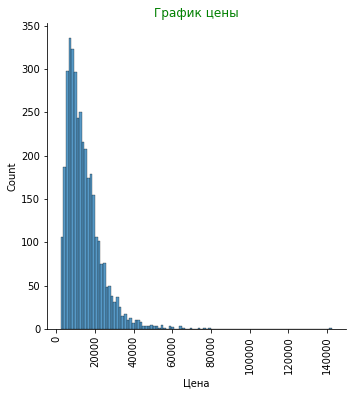

In [ ]:
#построим график
sns.displot(df['Цена'])
plt.title('График цены', color="green")
plt.xticks(rotation=90)
plt.show()

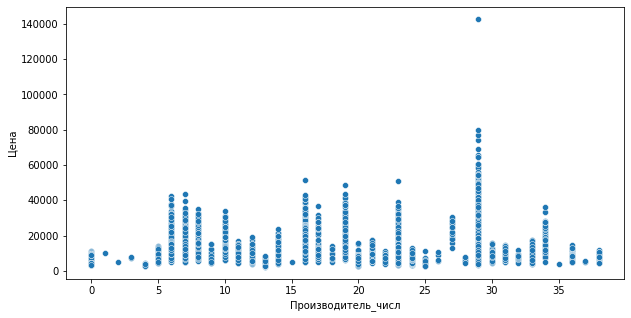

In [ ]:
# анализ зависимости цены от производителя
plt.figure(figsize = (10,5))
sns.scatterplot(x = 'Производитель_числ',y = 'Цена' ,data = df)

In [ ]:
# Посмотрим, кто производит самые дорогие шины
df.sort_values('Цена',ascending=False).head(30)

Производитель                                     Модель  Ширина  \
2359       Pirelli                            Scorpion Winter   325.0   
2188       Pirelli                Winter Sotto Zero Serie III   315.0   
925        Pirelli                   Scorpion Winter Run Flat   315.0   
413        Pirelli                   Scorpion Winter Run Flat   315.0   
915        Pirelli                            Scorpion Winter   315.0   
919        Pirelli                          Scorpion Winter 2   285.0   
412        Pirelli                   Scorpion Winter Run Flat   275.0   
1300       Pirelli                 Scorpion Winter 2 Run Flat   275.0   
1142       Pirelli                        Scorpion Ice Zero 2   315.0   
937        Pirelli                   Scorpion Winter Run Flat   315.0   
1960       Pirelli       Winter Sotto Zero Serie III Run Flat   275.0   
927        Pirelli                   Scorpion Winter Run Flat   275.0   
942        Pirelli       Winter Sotto Zero Serie III Run Flat   275.0   
1007       Pirelli                            Scorpion Winter   315.0   
2112       Pirelli                            Scorpion Winter   265.0   
946        Pirelli       Winter Sotto Zero Serie III Run Flat   275.0   
3340       Pirelli              P-Zero Luxury Saloon Run Flat   315.0   
1200       Pirelli       Winter Sotto Zero Serie III Run Flat   275.0   
3672       Pirelli  P-Zero Sports CAR Noise cancelling system   315.0   
3576       Pirelli                                      PZero   325.0   
1957       Pirelli       Winter Sotto Zero Serie III Run Flat   275.0   
1106       Pirelli                Winter Sotto Zero Serie III   275.0   
926        Pirelli                        P ZERO Winter Elect   285.0   
1527   Bridgestone                             LM001 Run Flat   285.0   
617        Pirelli                        Scorpion Ice Zero 2   285.0   
1046        Nokian                Tyres Hakkapeliitta 10p SUV   285.0   
940        Pirelli                   Scorpion Winter Run Flat   285.0   
999        Pirelli                            Scorpion Winter   295.0   
2023       Pirelli                            Scorpion Winter   285.0   
2823       Pirelli              P-Zero Luxury Saloon Run Flat   285.0   

      Профиль  Диаметр, R Индекс скорости  Индекс нагрузки      Цена  \
2359     35.0        22.0               W            114.0  142480.0   
2188     30.0        21.0               V            105.0   79920.0   
925      35.0        21.0               V            111.0   77120.0   
413      35.0        22.0               V            111.0   73900.0   
915      40.0        21.0               W            115.0   69210.0   
919      45.0        21.0               V            113.0   65690.0   
412      40.0        22.0               V            108.0   64880.0   
1300     40.0        22.0               V            108.0   64770.0   
1142     30.0        22.0               H            107.0   64660.0   
937      35.0        20.0               V            110.0   60800.0   
1960     40.0        18.0               V            103.0   60290.0   
927      40.0        21.0               V            107.0   59150.0   
942      40.0        19.0               V            105.0   59120.0   
1007     45.0        21.0               V            116.0   58210.0   
2112     40.0        22.0               W            106.0   56000.0   
946      35.0        20.0               V            102.0   55320.0   
3340     35.0        21.0               Y            111.0   54960.0   
1200     35.0        19.0               V            100.0   54620.0   
3672     30.0        21.0               Y            105.0   54540.0   
3576     35.0        20.0               Y            108.0   54200.0   
1957     40.0        20.0               V            106.0   53740.0   
1106     40.0        18.0               V            103.0   52650.0   
926      40.0        20.0               V            108.0   51720.0   
1527     45.0

In [ ]:
# Посмотрим, кто производит самые дешевые шины
df.sort_values('Цена',ascending=True).head(30)

Производитель                     Модель  Ширина  Профиль  Диаметр, R  \
2690          Кама                        244   165.0     70.0        13.0   
2472       Белшина          BEL-264 Artmotion   175.0     65.0        14.0   
3450       Белшина          BEL-253 Artmotion   175.0     70.0        13.0   
3426          Кама                 Breeze 132   175.0     70.0        13.0   
3460          Кама               365 (НК-241)   175.0     70.0        13.0   
3321          Кама                 Breeze 132   185.0     65.0        14.0   
2695          Кама                 Breeze 132   185.0     60.0        14.0   
2466          Кама             GRANT (НК-241)   185.0     60.0        14.0   
186           Кама                        505   175.0     70.0        13.0   
3424          Кама               365 (НК-241)   155.0     65.0        13.0   
1141         Tunga                  Nordway 2   175.0     70.0        13.0   
3459          Кама             GRANT (НК-241)   175.0     65.0        14.0   
220           Кама                        505   175.0     65.0        14.0   
119           Кама              ALGA (НК-531)   175.0     70.0        13.0   
227          Tunga                  Nordway 2   175.0     65.0        14.0   
2692        Viatti             Strada (V-130)   175.0     65.0        14.0   
2691          Кама               365 (НК-241)   185.0     65.0        14.0   
3468         Tunga                   Zodiak 2   175.0     70.0        13.0   
2720        Viatti             Strada (V-130)   175.0     70.0        13.0   
201           Кама              ALGA (НК-531)   175.0     65.0        14.0   
3427          Кама                 Breeze 132   185.0     70.0        14.0   
2673          Кама                 Breeze 132   195.0     65.0        15.0   
2694        Viatti             Strada (V-130)   185.0     60.0        14.0   
2443          Кама               365 (НК-241)   185.0     70.0        14.0   
3278       Белшина          Бел-254 Artmotion   185.0     65.0        14.0   
2446          Кама               365 (НК-241)   195.0     65.0        15.0   
2449        Viatti             Strada (V-130)   185.0     60.0        15.0   
27         Белшина      BEL-357 Artmotionsnow   175.0     65.0        14.0   
687           Кама                        505   185.0     60.0        14.0   
2412          Ling  Long Green-Max All Season   175.0     65.0        14.0   

     Индекс скорости  Индекс нагрузки    Цена  Производитель_числ  \
2690               N             79.0  2440.0                13.0   
2472               H             82.0  2520.0                25.0   
3450               T             82.0  2530.0                25.0   
3426               T             82.0  2540.0                13.0   
3460               H             82.0  2590.0                13.0   
3321               H             86.0  2610.0                13.0   
2695               H             82.0  2610.0                13.0   
2466               H             82.0  2660.0                13.0   
186                T             82.0  2660.0                13.0   
3424               T             73.0  2680.0                13.0   
1141               Q             82.0  2690.0                 4.0   
3459               H             82.0  2770.0                13.0   
220                T             82.0  2780.0                13.0   
119                T             82.0  2790.0                13.0   
227                Q             82.0  2820.0                 4.0   
2692               H             82.0  2860.0                20.0   
2691               H             86.0  2870.0                13.0   
3468               T             86.0  2870.0                 4.0   
2720               H             82.0  2880.0                20.0   
201                T             82.0  2920.0                13.0   
3427               T             88.0  2940.0                13.0   
2673               H             91.0  2950.0                13.0   

In [ ]:
# Результаты классификации производителей
df.groupby(['Производитель_числ'])['Модель'].count()

Производитель_числ
0.0     156
1.0       1
2.0       1
3.0       2
4.0      12
5.0      61
6.0     227
7.0     213
8.0     177
9.0      19
10.0    148
11.0     40
12.0     94
13.0     58
14.0    127
15.0      1
16.0    361
17.0     75
18.0     10
19.0    169
20.0    112
21.0     59
22.0     31
23.0    627
24.0    101
25.0     17
26.0      4
27.0     17
28.0      7
29.0    461
30.0     28
31.0     34
32.0     17
33.0    113
34.0     40
35.0      1
36.0     40
37.0      2
38.0     31
Name: Модель, dtype: int64

In [ ]:
# Из анализа данных: самые дорогие шины у Pirelli,
# самые дешевые - у российских производителей,
# Наимольший ассортимент по моделям представлены фирмами 
# Nokian (776 моделей), Pirelli (574) и Bridgestone (463)

In [ ]:
#оставляем для дальнейшего анализа выбранные столбцы
df = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']]
df.dropna (axis=0, inplace= True)
df.head()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Ширина  Профиль  Диаметр, R  Индекс нагрузки     Цена  Производитель_числ  \
0   215.0     65.0        17.0            103.0  11350.0                29.0   
1   195.0     65.0        15.0             95.0   7600.0                19.0   
2   225.0     50.0        17.0             98.0  10470.0                10.0   
3   215.0     55.0        16.0             97.0  11240.0                29.0   
4   245.0     45.0        17.0             99.0  17020.0                19.0   

   Индекс скорости_числ  
0                   5.0  
1                   5.0  
2                   5.0  
3                   5.0  
4                   0.0

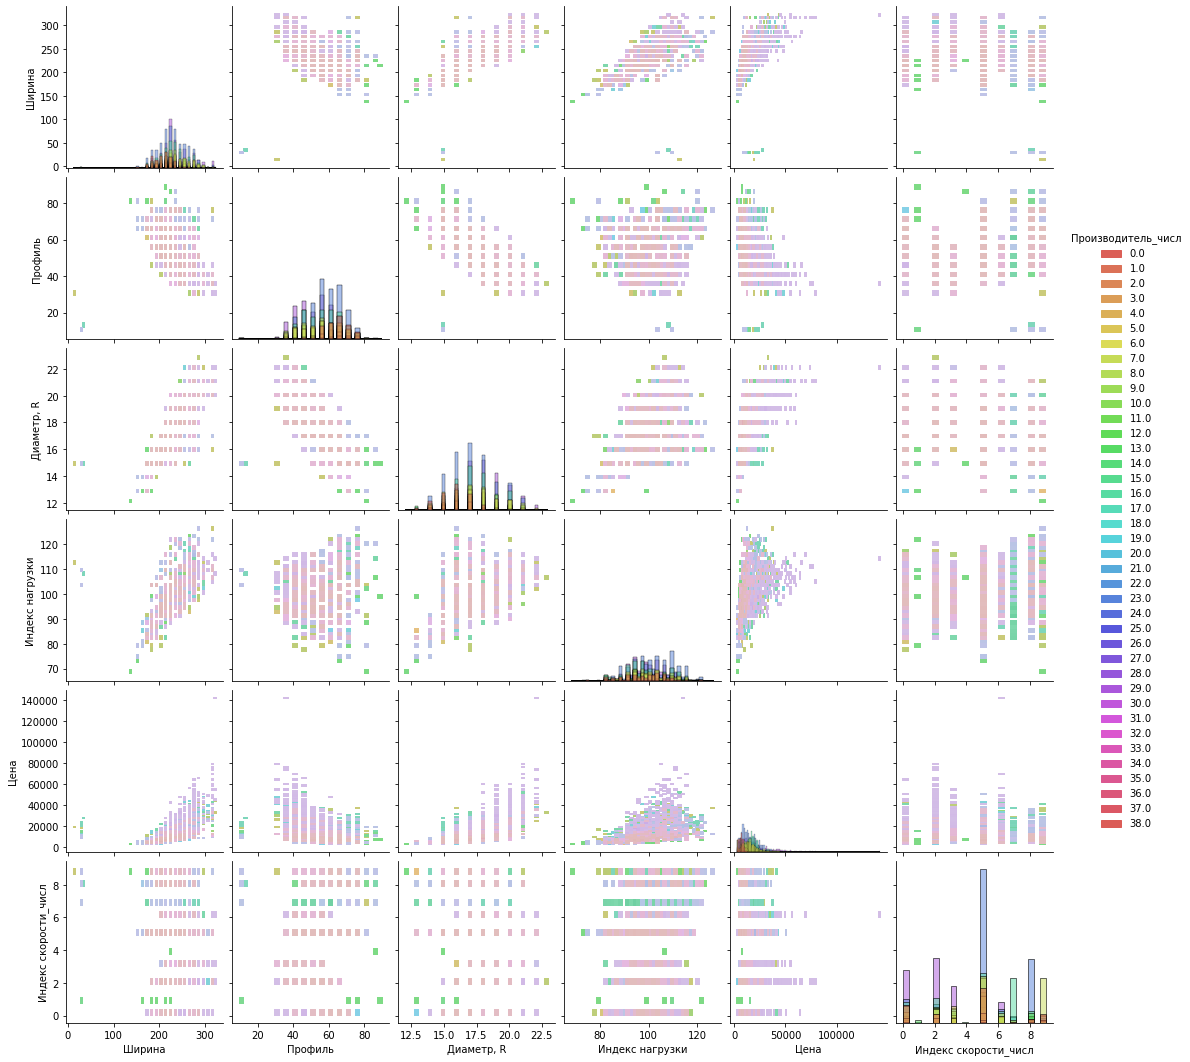

In [ ]:
# визуализируем все данные относительно производителя
sns.pairplot(df, hue = 'Производитель_числ', kind = 'hist', palette='hls')


In [ ]:
 # Из полученной визуализации можно предположить, что цена зависит от диаметра, ширины и профиля колес

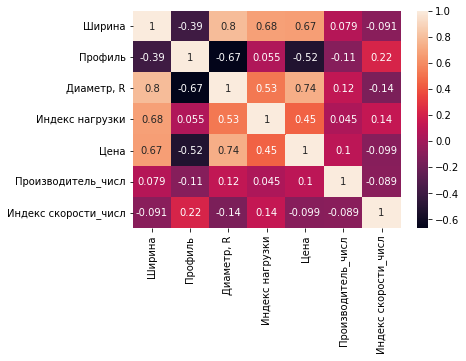

In [ ]:
# посмотрим на тепловую карту корреляции
numeric_col = ['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']
corr_matrix = df.loc[:,numeric_col].corr()
sns.heatmap(corr_matrix, annot=True)

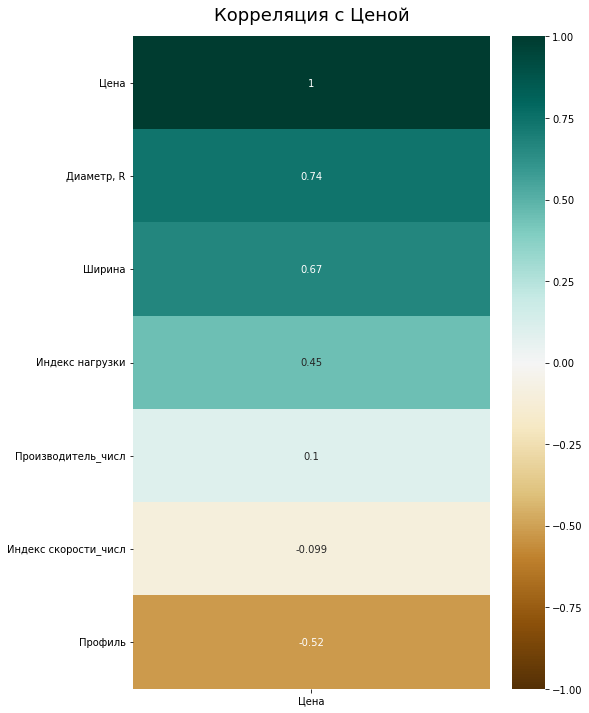

In [ ]:
# Корреляция независимых переменных с зависимой
df[['Цена']].sort_values(by='Цена', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Цена']].sort_values(by='Цена', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Корреляция с Ценой', fontdict={'fontsize':18}, pad=16);

In [ ]:
# Из полученных корреляционных матриц, мы видим, что переменные Диаметр и Ширина 
# имеют достаточно сильную корреляцию с целевой переменной Цена, 0,74 и 0,67, соответственно.
# Также умеренная корреляция наблюдается c переменной Профиль  и 'Индекс нагрузки'.

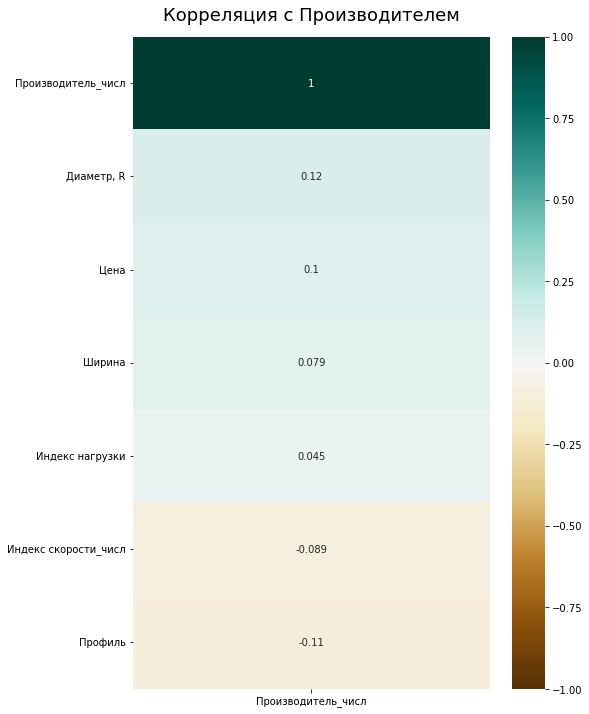

In [ ]:
# Корреляция с Производителем
df[['Производитель_числ']].sort_values(by='Производитель_числ', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['Производитель_числ']].sort_values(by='Производитель_числ', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Корреляция с Производителем', fontdict={'fontsize':18}, pad=16);

In [ ]:
# Проверим, сколько основных компонент необходимо исходя из 95-процентного правила
#  дисперсии исходного датасета

scaler = MinMaxScaler()
scaler.fit(df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']])
x = scaler.transform(df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Производитель_числ',	'Индекс скорости_числ']])
y=0
i=1
while y < 0.95:
  i += 1
  pca = PCA(n_components=i)
  pca.fit(x)
  var = pca.explained_variance_ratio_
  y = var.sum()
    
print('Минимальное количество основных компонент: ', i)
print('процентная дисперсия: ', y)

Минимальное количество основных компонент:  4
процентная дисперсия:  0.9689345208653304


In [ ]:
# попробуем выбрать переменные с помощью метода оболочки при целевой переменной - Производитель

X = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки','Цена',	'Индекс скорости_числ']]
Y = df[['Производитель_числ']]
x_new = sm.add_constant(X)
model = sm.OLS(Y, x_new).fit()
model.pvalues

selected_features = list(X.columns)
pmax = 1
while (len(selected_features)>0):
    p= []
    x_new = X[selected_features]
    x_new = sm.add_constant(x_new)
    model = sm.OLS(Y,x_new).fit()
    p = pd.Series(model.pvalues.values[1:],index = selected_features)      
    pmax = max(p)
    feature_pmax = p.idxmax()
    if(pmax>0.05):
        selected_features.remove(feature_pmax)
    else:
        break
selected_features

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future versi

['Диаметр, R', 'Индекс скорости_числ']

In [ ]:
# попробуем выбрать переменные с помощью метода оболочки при целевой переменной - Цена

X = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки','Производитель_числ',	'Индекс скорости_числ']]
Y = df[['Цена']]
x_new = sm.add_constant(X)
model = sm.OLS(Y, x_new).fit()
model.pvalues

selected_features = list(X.columns)
pmax = 1
while (len(selected_features)>0):
    p= []
    x_new = X[selected_features]
    x_new = sm.add_constant(x_new)
    model = sm.OLS(Y,x_new).fit()
    p = pd.Series(model.pvalues.values[1:],index = selected_features)      
    pmax = max(p)
    feature_pmax = p.idxmax()
    if(pmax>0.05):
        selected_features.remove(feature_pmax)
    else:
        break
selected_features

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки']

In [ ]:
# После того, как собрано достаточно данных о взаимосвязи переменных, можно начать отбор наиболее значимых признаков.
# Возьмем все переменные, поскольку они имеют низкую корреляцию с целевой переменной 'Производитель_числ' 


In [ ]:
***************************************************************************

In [ ]:
x_value = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена', 'Индекс скорости_числ']].values
y_value = df['Производитель_числ'].values


In [ ]:
# этот код тестовый - для определения оптималоной величины - random_state
for i in range(42,150):
  x_train, x_test, y_train, y_test = train_test_split(x_value, y_value, 
                                                    test_size = 0.2, 
                                                    random_state = i)
  #x_train = st.fit_transform(x_train)
  #x_test = st.transform(x_test)
  model = LinearRegression()
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  R2 = sklearn.metrics.r2_score (y_test, pred)
  print('i =', i ,', R2=', R2)

In [ ]:
# разделим данные на обучающую выборку и проверочную
x_train, x_test, y_train, y_test = train_test_split(x_value, y_value, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [ ]:
# масштабируем данные
st = StandardScaler() 
x_train = st.fit_transform(x_train)
x_test = st.transform(x_test)

In [ ]:
# создаем объект класса линейной регрессии
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [ ]:
#провеpка
print(pred[0], y_test[0])

17.484568546322798 23.0


In [ ]:
# Посмотрим на метрики регрессии

In [ ]:
# оценка качества модели
MAE = sklearn.metrics.mean_absolute_error(y_test, pred)
MAPE = sklearn.metrics.mean_absolute_percentage_error(y_test, pred)
R2 = sklearn.metrics.r2_score (y_test, pred)
print('MAE=', MAE , ', MAPE=', MAPE ,', R2=', R2)

MAE= 7.993830541996934 , MAPE= 3632948066403935.5 , R2= 0.025255238868396312


In [ ]:
# Посмотрим как сработает метод опорных векторов
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [ ]:
# создадим модель класса SVC
model_SVC = SVC(kernel='linear', gamma='scale', shrinking=False)
model_SVC.fit(x_train, y_train)

In [ ]:
model_SVC.support_vectors_

array([[-0.42007593,  1.34204127, -1.21648054,  1.04705144, -0.67177732,
         1.43906352],
       [ 0.21350612,  0.41380863,  0.46752635,  0.81426328, -0.51376735,
        -0.9358966 ],
       [-0.42007593, -0.0503077 , -0.65514491, -0.81525387, -0.87067099,
        -0.9358966 ],
       ...,
       [-1.05365799, -0.0503077 , -0.65514491, -1.51361836, -0.8419419 ,
         0.25158346],
       [-0.1032849 ,  0.41380863, -0.09380928,  0.34868695, -0.64967802,
        -1.72754998],
       [ 0.21350612,  1.80615759, -1.21648054,  0.58147512, -0.43420988,
         0.25158346]])

In [ ]:
# проверим работу модели
pred = model_SVC.predict(x_test)
print(pred[:15])
print(y_test[:15])

[23.  0. 23. 16.  6. 29. 29. 29. 16. 23. 23.  0. 29. 23. 29.]
[23. 24. 11. 19. 16. 29. 29. 23. 10.  8. 23. 20.  6. 23. 29.]


In [ ]:
accuracy_score(y_test, pred) # доля верных ответов

0.2732191163210099

In [ ]:
# Точность
print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))

0.1243953459044466
0.2732191163210099
0.21783185990351528


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**************************************

In [ ]:
x = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена']]
y = df['Производитель_числ']

In [ ]:
# разделим данные на обучающую выборку и проверочную
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
# метод к-ближних соседей
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(39)
knn = knn.fit(x_train, y_train)

In [ ]:
pred = knn.predict(x_test)
print(pred[:15])
print(y_test[:15])

[ 8. 23.  0. 22. 16. 23. 16. 20. 23. 29. 23. 23. 16. 16. 23.]
393     23.0
3561    19.0
551     33.0
1295    33.0
818     16.0
2662    24.0
567     23.0
1727    30.0
1565    16.0
2084    23.0
298     14.0
109     29.0
2271     8.0
2934    29.0
1334    16.0
Name: Производитель_числ, dtype: float64


In [ ]:
accuracy_score(y_test, pred) # доля верных ответов

0.18538565629228687

In [ ]:
# Точность
print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))

0.05969710038478245
0.18538565629228687
0.13823822918012246


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**************************************

In [ ]:
# дерево решений

from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc = dtc.fit(x, y)


In [ ]:
pred = dtc.predict(x_test)
print(pred[:15])
print(y_test[:15])

[23. 19. 33. 33. 16. 24. 23. 30. 16. 23. 14. 29.  8. 29. 16.]
393     23.0
3561    19.0
551     33.0
1295    33.0
818     16.0
2662    24.0
567     23.0
1727    30.0
1565    16.0
2084    23.0
298     14.0
109     29.0
2271     8.0
2934    29.0
1334    16.0
Name: Производитель_числ, dtype: float64


In [ ]:
accuracy_score(y_test, pred) # доля верных ответов

1.0

In [ ]:
# Точность
print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))

1.0
1.0
1.0


In [ ]:
test = {'Ширина': [255], 'Профиль': [55], 'Диаметр, R': [18], 'Индекс нагрузки': [109], 'Цена': [20000]}
test_df = pd.DataFrame(test)
test_df.head()

Ширина  Профиль  Диаметр, R  Индекс нагрузки   Цена
0     255       55          18              109  20000

In [ ]:
v = dtc.predict(test_df)
print(v[0])

23.0


**************************************

In [ ]:
# Градиентный бустинг
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc = gbc.fit(x, y)

In [ ]:
pred = gbc.predict(x_test)
print(pred[:15])
print(y_test[:15])

[29. 16. 33.  0. 16. 24. 23. 30. 16. 23. 14. 29. 16. 29. 29.]
393     23.0
3561    19.0
551     33.0
1295    33.0
818     16.0
2662    24.0
567     23.0
1727    30.0
1565    16.0
2084    23.0
298     14.0
109     29.0
2271     8.0
2934    29.0
1334    16.0
Name: Производитель_числ, dtype: float64


In [ ]:
# Точность
print(precision_score(y_test, pred, average='macro'))
print(precision_score(y_test, pred, average='micro'))
print(precision_score(y_test, pred, average='weighted'))

0.8672767491193837
0.6373477672530447
0.705767911934403


In [ ]:
test = {'Ширина': [255], 'Профиль': [55], 'Диаметр, R': [18], 'Индекс нагрузки': [109], 'Цена': [20000]}
test_df = pd.DataFrame(test)
test_df.head()

Ширина  Профиль  Диаметр, R  Индекс нагрузки   Цена
0     255       55          18              109  20000

In [ ]:
g = gbc.predict(test_df)
print(g[0])

23.0


In [ ]:
# "Градиентный бустинг" и "Дерево решений" показывают высокую точность 
# предсказаний по производителю

***************************************

Создание модели на основе нейросети

In [ ]:
# Прогноз производителя

In [ ]:
x_value = df[['Ширина', 'Профиль', 'Диаметр, R', 'Индекс нагрузки', 'Цена']].values
y_value = df['Производитель_числ'].values

In [ ]:
# разделим данные на обучающую выборку и проверочную
x_train, x_test, y_train, y_test = train_test_split(x_value, y_value, 
                                                    test_size = 0.2, 
                                                    random_state = 102)

In [ ]:
# удалить
scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)


In [ ]:
model2 = Sequential()
# число нейронов  и слоев подобрано экспериментально
model2.add(Dense(5, input_dim=5, activation='relu'))
model2.add(Dense(39, activation='relu'))
model2.add(Dense(60, activation='relu'))
model2.add(Dense(60, activation='relu'))
model2.add(Dense(39))

model2.compile(optimizer='adagrad', loss='mse')

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 39)                234       
                                                                 
 dense_2 (Dense)             (None, 60)                2400      
                                                                 
 dense_3 (Dense)             (None, 60)                3660      
                                                                 
 dense_4 (Dense)             (None, 39)                2379      
                                                                 
Total params: 8,703
Trainable params: 8,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(x_value, y_value,
         validation_data=(x_test,y_test), epochs = 4000) #, verbose=0)

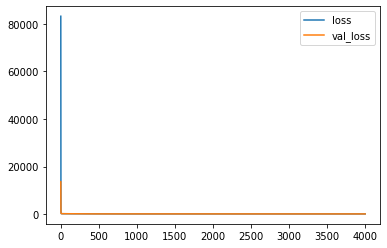

In [ ]:
losses = pd.DataFrame(model2.history.history)
losses.plot()

In [ ]:
# сохраним модель
model2.save('model_2.h5')

In [ ]:
# загрузим свою модель после перерыва
model2 = load_model('/content/model_2.h5')


In [ ]:
pred = model2.predict(x_test)
MAE = sklearn.metrics.mean_absolute_error(y_test, np.argmax(pred, axis = 1))
MAPE = sklearn.metrics.mean_absolute_percentage_error(y_test, np.argmax(pred, axis = 1))
R2 = sklearn.metrics.r2_score (y_test, np.argmax(pred, axis = 1))
print('MAE=', MAE , ', MAPE=', MAPE ,', R2=', R2)

24/24 [==============================] - 0s 4ms/step
MAE= 9.484438430311231 , MAPE= 4649859967095654.0 , R2= -0.813782043476442


In [ ]:
# передадим модели последние 10 данных выборки
pred = model2.predict(x_test[-10:])
# для кажого изображения (то есть строки, axis = 1)
# выведем индекс (максимальное значение), это и будет той цифрой, которую мы прогнозируем
print(np.argmax(pred, axis = 1))

# остается сравнить с целевой переменной
print(y_test[-10:])

1/1 [==============================] - 0s 37ms/step
[10 14 33  7 16 14 33 14 16 14]
[31. 19. 23. 29. 16. 19. 16. 23. 14. 17.]


In [ ]:
pred = model2.predict(x_test)
mean_squared_error(y_test, np.argmax(pred, axis = 1))

24/24 [==============================] - 0s 1ms/step


148.9215155615697

In [ ]:
np.sqrt(mean_squared_error(y_test, np.argmax(pred, axis = 1)))

12.20334034441266

In [ ]:
explained_variance_score(y_test, np.argmax(pred, axis = 1))

-0.8137193978850992

In [ ]:
test = {'Ширина': [185], 'Профиль': [70], 'Диаметр, R': [14], 'Индекс нагрузки': [110], 'Цена': [10000]}
test_df = pd.DataFrame(test)
g = model2.predict(test_df)
print(np.argmax(g, axis = 1))

1/1 [==============================] - 0s 175ms/step
[16]


Судя по всему, набор данных слишком однородный, раз такой результат. Пробовала достаточно долго разные модификации модели: меняла число нейронов, количество слоев, разные оптимизаторы...

In [ ]:
-----------------------